In [1]:
import numpy as np
import theano
import theano.tensor as tt
import pymc3 as pm
import datetime
import pandas as pd

import time
import pickle

import matplotlib.pyplot as plt
import matplotlib
theano.config.optimizer='fast_run'
theano.config.floatX = "float64"

# Legend-formating for matplotlib
def _format_k(prec):
    """
        format yaxis 10_000 as 10 k.
        _format_k(0)(1200, 1000.0) gives "1 k"
        _format_k(1)(1200, 1000.0) gives "1.2 k"
    """

    def inner(xval, tickpos):
        return f"${xval/1_000:.{prec}f}\,$k"

    return inner


In [2]:
def plain_SIR_model(beta,gamma,N,S0,I0,R0,l=150):
    """Simple classical SIR-Model with time-constant beta,gamma"""
    def next_day(t,St,It,Rt,oS,oI,oR,eff,beta,gamma,N):
        eff = beta*St/N
        bSIoN = eff * It # -beta * (S*I)/N
        gI = gamma*It
        # Calculate differences
        dS = -bSIoN
        dI = bSIoN - gI
        dR = gI
        # Update values
        nxt_St = St + dS
        nxt_It = It + dI
        nxt_Rt = Rt + dR
        
        nxt_St = tt.clip(nxt_St,0,1e16) # Improves sampling stability
        
        # Pass on to next step
        return nxt_St,nxt_It,nxt_Rt, dS,dI,dR, eff
        
    # Initial internal state
    zero = tt.cast(0.,dtype='float64')
    initial_state = [S0,I0,R0,zero,zero,zero,zero]
    sequences = [tt.arange(l)]
    # Exceute the 'Loop'
    state,_ = theano.scan(fn=next_day,
                            sequences=sequences,# time dependent sequences can be passed as first params
                            outputs_info=initial_state,
                            non_sequences=[beta,gamma,N])
    return state


def Gompertz(a,b,c,l=150):
    t = tt.arange(l)
    return a*tt.exp(-b*tt.exp(-c*t))

In [7]:
# Data from
#https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
#Germany,51.165690999999995,10.451526,
jhu_deaths = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,3,3,7,9,11,17,24,28,44,67,84,94,123,157,206,267,342,433,533,645,775,920,1107,1275,1444,1584,1810,2016,2349,2607,2767,2736,3022,3194,3294,3804,4052,4352,4459,4586,4862,5033,5279,5575,5760,5877,5976,6126,6314,6467,6623,6736,6812,6866,6993,6993,7275,7392,7510,7549,7569,7661,7738,7861,7884,7897,7938,7962,8003,8081,8144,8203,8228,8261,8283,8309,8372,8428,8470,8504,8530,8540,8555,8563,8602,8635,8658,8673,8685,8695,8736,8752,8772,8783,8793,8801,8807,8820,8851,8875,8887,8895,8895,8899,8914,8928,8940,8965,8968,8968,8976,8990,8995,9006,9010,9020,9023,9022,9032,9046,9057,9063,9070,9071,9074,9078,9080,9087,9088,9091,9092,9094,9099,9102,9110,9120,9124,9124,9125,9131,9135,9144,9147,9154,9154,9154,9163,9179,9181,9195,9201,9202,9203,9208,9213,9217,9230,9235,9235,9236,9241,9249,9263,9266,9272,9275,9276,9281,9285,9290,9290,9299]
jhu_ts = pd.date_range(datetime.date(2020,1,21),periods=len(jhu_deaths),freq='D')

# Limit to non-zero values, dropping the front of the list
first_non_zero_index = 47
jhu_deaths1 = jhu_deaths[first_non_zero_index:]
jhu_ts1 = jhu_ts[first_non_zero_index:]
print("first non zero deaths timestamp",jhu_ts1[0])

# Alternative Deaths from Situation-report graph of actual dates of deaths
rki_deaths_per_day = [1, 1, 1, 1, 5, 2, 3, 4, 11, 13, 12, 21, 40, 24, 42, 42, 67, 76, 92, 104, 107, 114, 172, 165, 162, 204, 199, 223, 240, 240, 254, 260, 257, 240, 246, 239, 243, 245, 227, 239, 241, 191, 203, 209, 172, 194, 157, 163, 129, 141, 132, 125, 128, 121, 106, 76, 92, 78, 93, 82, 69, 54, 63, 64, 63, 42, 54, 66, 47, 29, 40, 44, 45, 47, 31, 33, 27, 30, 31, 23, 21, 18, 19, 17, 18, 24, 15, 18, 18, 14, 8, 9, 8, 6, 11, 11, 14, 9, 6, 9, 7, 7, 9, 6, 3, 4, 4, 6, 7, 7, 7, 4, 7, 8, 1]
rki_deaths = np.cumsum(rki_deaths_per_day)
rki_ts = pd.date_range(datetime.date(2020,3,8),periods=len(rki_deaths),freq='D')

sources = {"jhu":(jhu_deaths,jhu_ts),"jhu1":(jhu_deaths1,jhu_ts1),"rki":(rki_deaths,rki_ts)}

deaths,ts = sources["jhu1"]

#t_lables = []

first non zero deaths timestamp 2020-03-08 00:00:00


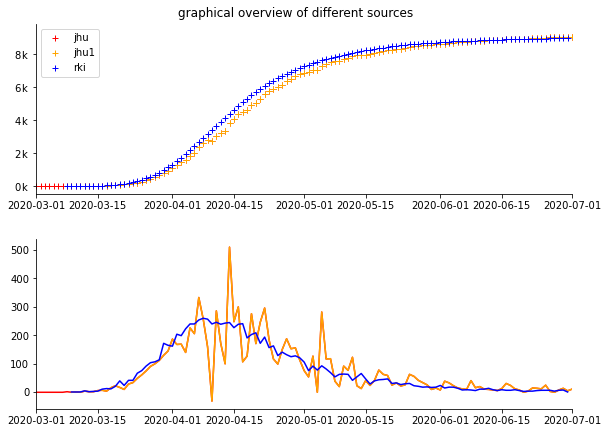

In [8]:
fig = plt.figure(figsize=(8,6))
fig.subplots_adjust(wspace=0.33,hspace=0.27,left=0.05,right=0.98,top=0.94,bottom=0.05)
fig.suptitle("graphical overview of different sources")
gs = fig.add_gridspec(2, 1)

ax = fig.add_subplot(gs[0,0])
bx = fig.add_subplot(gs[1,0])

i = 0
color=["red","orange","blue"]
for k,v in sources.items():
   
    d,t = v
    ax.plot(t,d,'+',label=k,color=color[i])
    bx.plot(t[1:],np.diff(d),label=k,color=color[i])
    i+=1
    
ax.set_xlim([datetime.date(2020,3,1),datetime.date(2020,7,1)])
bx.set_xlim([datetime.date(2020,3,1),datetime.date(2020,7,1)])
ax.legend()
    
for tx in [ax,bx]:
    prec = 1.0 / (np.log10(tx.get_ylim()[1]) - 2.5)
    if prec < 2.0 and prec >= 0:
        tx.yaxis.set_major_formatter(
            matplotlib.ticker.FuncFormatter(_format_k(int(prec)))
        )
    tx.spines['top'].set_visible(False)
    tx.spines['right'].set_visible(False)
        

In [11]:
# Test simple SIR-Fit beta,gamma,N,I0

def FitSIRModel(data,l=90,initial={},fit_I0=True,fit_differences=False):
    """
    Fit SIR model using HamiltonianMonteCarlo No-UTurn-Sampler 
        fit_0 : Allow fitting I0 else I0 = 1
        fit_differences : False # keep it that way until daily differences are of interest and not total numbers
    """
    with pm.Model() as model:
        # Setup Priors for beta,gamma
        beta = pm.Lognormal(name="beta",
                        mu=tt.log(tt.cast(.4,dtype='float64')),
                        sigma=tt.cast(.4,dtype='float64')) # Choose both beta and gamma wide enough
        gamma = pm.Lognormal(name="gamma",
                         mu=tt.log(tt.cast(.13,dtype='float64')),
                         sigma=tt.cast(.3,dtype='float64'))
        beta = tt.clip(beta,gamma,1e3) # Ensure positive initial growth, improves sampling
    
#        N = tt.cast(83e6,dtype='float64')
        N = pm.Lognormal(name="N",mu=tt.log(tt.cast(10000,dtype='float64')),sigma=tt.cast(.95,dtype='float64'))
        S0 = N
        if fit_I0: # Eiher fit or don't fit I0
            I0 = pm.Lognormal(name="I0",
                      mu=tt.log(tt.cast(1.,dtype='float64')),
                      sigma=tt.cast(.5,dtype="float64")
                     )
        else:
            I0 = tt.cast(1,dtype='float64')
    
        R0 = tt.cast(0.,dtype='float64')
    
        # Run the Model
        S_t,I_t,R_t,dS,dI,dR,eff = plain_SIR_model(beta,gamma,N,S0,I0,R0,l=l)
        # Store Model output in Trace
        pm.Deterministic("S_t",S_t)
        pm.Deterministic("I_t",I_t)
        pm.Deterministic("R_t",R_t)
        pm.Deterministic("dR",dR)
        pm.Deterministic("dS",dS)
        
        # Loglike-estimate
        if fit_differences: # Fit differences, which might me more suitable for the Sampler
            est_deaths = dR
            sigma_obs = pm.HalfCauchy( name="sigma", beta=10 )
            pm.StudentT(
                    name="like_studentT",
                    nu=4,
                    mu=est_deaths,
                    sigma=tt.abs_(est_deaths + 1) ** 0.5 * sigma_obs,
                    observed=np.diff(deaths1[:l+1])
            )
        else: # Leads to tighter fit to the non-differentiated data
            est_deaths = R_t
            sigma_obs = pm.HalfCauchy( name="sigma", beta=50 )
            pm.StudentT(
                    name="like_studentT",
                    nu=4,
                    mu=est_deaths,
                    sigma=tt.abs_(est_deaths + 1) ** 0.5 * sigma_obs,
                    observed=data[:l]
            )
        
        # Handle Chained sampling reusing previous fit as starting-point
        init = "advi+adapt_diag" if len(initial) == 0 else None
        trace = pm.sample( model=model,init=init,start=initial,draws=1200,tune=1200,cores=4,chains=4)#,max_treedepth=16)
        return trace

In [12]:
def SIRSeries(data,start=30,end=120,fit_I0=True):
    estimates = {}
    tr = None
    for l in range(start,end+1):
        initial = {} if tr == None else {'beta':np.mean(tr.beta),'gamma':np.mean(tr.gamma),'N':np.mean(tr.N)}
        if fit_I0 and tr != None:
            initial['I0'] = np.mean(tr.I0)
            
        tr = FitSIRModel(data=data,l=l,initial=initial,fit_I0=fit_I0)
        ssd = np.sum(np.power(data[:l]-np.mean(tr.R_t,axis=0),2))
        estimates[l] = {'beta':tr.beta,'gamma':tr.gamma,'N':tr.N,"ssd":ssd}
        if fit_I0:
            estimates[l]["I0"] = tr.I0
    return estimates

sir_est = SIRSeries(deaths,30,30)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 18300
Interrupted at 18,299 [9%]: Average Loss = 199.66
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 349 seconds.
The acceptance probability does not match the target. It is 0.7109736866849645, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6446203962299036, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [14]:
with open("estimates/sir_%d"%time.time(),"wb+") as f:
    pickle.dump(sir_est,f)

for k,v in sir_est.items():
    print(k,v["ssd"])
    for p in ['beta','gamma','N','I0']:
        print("\t",p,np.mean(v[p]),np.percentile(v[p],q=(2.5,5,50,95,97.5)))

30 5269.411830870749
	 beta 0.4704139720986383 [0.40785984 0.41484264 0.46426944 0.53994607 0.55726566]
	 gamma 0.1634962493032887 [0.09848369 0.10560978 0.15741871 0.23478506 0.25476471]
	 N 3666.948376783841 [3344.36322277 3399.93548742 3625.11080121 4082.63630822 4199.07739066]
	 I0 4.755355028368283 [2.96347073 3.17356773 4.67331751 6.85105673 7.34091444]


In [297]:
def FitGompertz(data,l=90,initial={}):
    with pm.Model() as model:
        a = pm.Lognormal(name="a",
                    mu=tt.log(tt.cast(1e5,dtype='float64')),
                    sigma=tt.cast(.6,dtype='float64'))
        b = pm.Lognormal(name="b",
                    mu=tt.log(tt.cast(11,dtype='float64')),
                    sigma=tt.cast(.8,dtype='float64'))
        c = pm.Lognormal(name="c",
                    mu=tt.log(tt.cast(.07,dtype='float64')),
                    sigma=tt.cast(.8,dtype='float64'))
    
        est = Gompertz(a,b,c,l)
        est_deaths = pm.Deterministic("deaths",est)
    
        sigma_obs = pm.HalfCauchy( name="sigma", beta=40 )
        pm.StudentT(
                    name="like_studentT",
                    nu=4,
                    mu=est_deaths,
                    sigma=tt.abs_(est_deaths + 1) ** 0.5 * sigma_obs,
                    observed=data[:l]
        )
        init = "advi+adapt_diag" if len(initial) == 0 else None
        trace = pm.sample( model=model,init=init,start=initial,draws=2000,tune=2000,cores=4,chains=4)
        return trace

In [298]:
def GompertzSeries(data,start=30,end=120):
    estimates = {}
    tr = None
    for l in range(start,end+1):
        initial = {} if tr == None else {'a':np.mean(tr.a),'b':np.mean(tr.b),'c':np.mean(tr.c)}
        tr = FitGompertz(data,l=l,initial=initial)
        ssd = np.sum(np.power(data[:l]-np.mean(tr.deaths,axis=0),2))
        estimates[l] = {'a':tr.a,'b':tr.b,'c':tr.c,"ssd":ssd}
    return estimates

gomp_est = GompertzSeries(deaths1,30,40)


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 9700
Interrupted at 9,699 [4%]: Average Loss = 242.58
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 37 seconds.
The acceptance probability does not match the target. It is 0.5777923100189537, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 35 seconds.
The acceptance probability does not match the target. It is 0.6189950072375493, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 39 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 37 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 39 seconds.
The acceptance probability does not match the target. It is 0.617936064528863, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 37 seconds.
The acceptance probability does not match the target. It is 0.6672363838868505, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 35 seconds.
The acceptance probability does not match the target. It is 0.6918920496643236, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7052076546931955, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 31 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 29 seconds.
The acceptance probability does not match the target. It is 0.695551555667098, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.8813860781824362, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 26 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [310]:
with open("estimates/gomp_%d"%time.time(),"wb+") as f:
    pickle.dump(gomp_est,f)

for k,v in gomp_est.items():
    print(k,v["ssd"])
    for p in ['a','b','c']:
        print("\t",p,np.mean(v[p]),np.percentile(v[p],q=(2.5,5,50,95,97.5)))


30 23013.263106935
	 a 26609.02053293102 [16536.95690718 17328.58062093 25215.1984961  40789.88193267
 45657.13383123]
	 b 10.455550039078055 [10.18708897 10.21763916 10.44769533 10.71209694 10.77448495]
	 c 0.049478630679098176 [0.04338753 0.0443731  0.04951941 0.05456866 0.0551854 ]
31 19357.411937789795
	 a 24524.872119171552 [17478.31396668 18277.0963506  23697.39011652 33264.58549757
 35762.39492971]
	 b 10.408325914841532 [10.20203458 10.23270387 10.40503094 10.59094949 10.63024432]
	 c 0.050071790207413515 [0.04515599 0.04591153 0.05017018 0.05406791 0.05465502]
32 17673.133717551966
	 a 23059.124312052332 [17405.17171813 18080.57969244 22654.33871397 29230.61299634
 31378.57294098]
	 b 10.377707986795961 [10.18869652 10.21886448 10.37508145 10.5488572  10.58325349]
	 c 0.05065402796435458 [0.04627325 0.04716999 0.05062645 0.05421196 0.05488493]
33 28515.635776036732
	 a 20798.397549432968 [15242.69388456 15938.99395907 20567.24644416 26492.6223631
 27858.06587108]
	 b 10.357312

In [ ]:
trace = FitGompertz(l=30)
plt.plot(ts1[:l],deaths1[:l],"+")
plt.plot(ts1[:l],trace.deaths[0])
plt.fill_between(ts1[:l],*np.percentile(trace.deaths,axis=0,q=(2.5,97.5)),color="orange",alpha=.2)

gomp_est = np.mean(trace.deaths,axis=0)
print(SSD(deaths1[:1],gomp_est))
